In [74]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [75]:
feature_id = 20
CONVERTED_DATABASE_NAME = '/Volumes/Samsung_T5/UPS2_DIA_180907/UPS2_DIA_180907.sqlite'
SUMMED_REGIONS_DATABASE = '/Volumes/Samsung_T5/UPS2_DIA_180907/UPS2_DIA_180907-features-{}-{}.sqlite'.format(feature_id, feature_id)

In [76]:
# set up indexes
db_conn = sqlite3.connect(CONVERTED_DATABASE_NAME)
db_conn.cursor().execute("DROP INDEX IF EXISTS idx_raw_summed_join_1")
db_conn.cursor().execute("DROP INDEX IF EXISTS idx_frames_4")
db_conn.cursor().execute("CREATE INDEX idx_raw_summed_join_1 ON raw_summed_join (summed_frame_point)")
db_conn.cursor().execute("CREATE INDEX idx_frames_4 ON frames (raw_frame_point)")
db_conn.close()

db_conn = sqlite3.connect(SUMMED_REGIONS_DATABASE)
db_conn.cursor().execute("DROP INDEX IF EXISTS idx_ms1_feature_frame_join_1")
db_conn.cursor().execute("CREATE INDEX idx_ms1_feature_frame_join_1 ON ms1_feature_frame_join (feature_id)")
db_conn.close()

In [77]:
db_conn = sqlite3.connect(SUMMED_REGIONS_DATABASE)
summed_ms1_region_df = pd.read_sql_query("select * from summed_ms1_regions where feature_id={} order by peak_id".format(feature_id), db_conn)
db_conn.close()

In [78]:
summed_ms1_region_df.head()

,feature_id,point_id,mz,retention_time_secs,scan,intensity,number_frames,peak_id,feature_point
0,20,1,594.795346,393.262963,403,12401,14,1,20|1
1,20,4,594.797550,393.218921,404,15025,14,1,20|4
2,20,7,594.796218,393.201234,405,22245,15,1,20|7
3,20,10,594.796612,393.288341,406,26007,15,1,20|10
4,20,13,594.796649,393.248910,407,34729,15,1,20|13


In [79]:
summed_ms1_region_df.rename(columns={"peak_id":"feature_peak_id","point_id":"feature_point_id"}, inplace=True)

In [80]:
summed_ms1_region_df.drop(['mz', 'scan', 'intensity', 'number_frames'], axis=1, inplace=True)

In [81]:
summed_ms1_region_df.head()

,feature_id,feature_point_id,retention_time_secs,feature_peak_id,feature_point
0,20,1,393.262963,1,20|1
1,20,4,393.218921,1,20|4
2,20,7,393.201234,1,20|7
3,20,10,393.288341,1,20|10
4,20,13,393.248910,1,20|13


In [82]:
# add the summed_frame_point that contributed to each feature region point
db_conn = sqlite3.connect(SUMMED_REGIONS_DATABASE)
ms1_feature_frame_join_df = pd.read_sql_query("select * from ms1_feature_frame_join where feature_id={}".format(feature_id), db_conn)
db_conn.close()

In [83]:
ms1_feature_frame_join_df.head()

,feature_id,feature_point_id,frame_id,frame_point_id,feature_point,summed_frame_point
0,20,1,297,4746,20|1,297|4746
1,20,1,298,4653,20|1,298|4653
2,20,1,300,4750,20|1,300|4750
3,20,1,303,5052,20|1,303|5052
4,20,1,304,5121,20|1,304|5121


In [84]:
ms1_feature_frame_join_df.rename(columns={"frame_id":"summed_frame_id"}, inplace=True)

In [85]:
ms1_feature_frame_join_df.drop(['feature_id', 'feature_point_id', 'frame_point_id'], axis=1, inplace=True)

In [86]:
ms1_feature_frame_join_df.head()

,summed_frame_id,feature_point,summed_frame_point
0,297,20|1,297|4746
1,298,20|1,298|4653
2,300,20|1,300|4750
3,303,20|1,303|5052
4,304,20|1,304|5121


In [87]:
summed_ms1_region_df = pd.merge(summed_ms1_region_df, ms1_feature_frame_join_df, how='left', left_on=['feature_point'], right_on=['feature_point'])

In [88]:
summed_ms1_region_df.drop(['feature_point'], axis=1, inplace=True)

In [89]:
summed_ms1_region_df.head()

,feature_id,feature_point_id,retention_time_secs,feature_peak_id,summed_frame_id,summed_frame_point
0,20,1,393.262963,1,297,297|4746
1,20,1,393.262963,1,298,298|4653
2,20,1,393.262963,1,300,300|4750
3,20,1,393.262963,1,303,303|5052
4,20,1,393.262963,1,304,304|5121


In [90]:
# add the raw_frame_point that contributed to each summed frame point
db_conn = sqlite3.connect(CONVERTED_DATABASE_NAME)
%timeit raw_summed_join_df = pd.read_sql_query("select * from raw_summed_join where summed_frame_point in {}".format(tuple(summed_ms1_region_df.summed_frame_point.astype(str))), db_conn)
db_conn.close()

100 loops, best of 3: 11.7 ms per loop


In [91]:
raw_summed_join_df.head()

,raw_frame_id,raw_point_id,summed_frame_point,raw_frame_point
0,5108,16886,297|4746,5108|16886
1,5112,16772,297|4746,5112|16772
2,5108,17003,297|4789,5108|17003
3,5112,16898,297|4789,5112|16898
4,5108,17124,297|4833,5108|17124


In [94]:
summed_ms1_region_df = pd.merge(summed_ms1_region_df, raw_summed_join_df, how='left', left_on=['summed_frame_point'], right_on=['summed_frame_point'])

In [95]:
summed_ms1_region_df.drop(['summed_frame_id','summed_frame_point','retention_time_secs'], axis=1, inplace=True)

In [96]:
summed_ms1_region_df.head()

,feature_id,feature_point_id,feature_peak_id,raw_frame_id,raw_point_id,raw_frame_point
0,20,1,1,5108,16886,5108|16886
1,20,1,1,5112,16772,5112|16772
2,20,1,1,5112,16772,5112|16772
3,20,1,1,5118,17340,5118|17340
4,20,1,1,5120,17204,5120|17204


In [97]:
# get the raw frame point's intensity
db_conn = sqlite3.connect(CONVERTED_DATABASE_NAME)
raw_frames_df = pd.read_sql_query("select * from frames where raw_frame_point in {}".format(tuple(summed_ms1_region_df.raw_frame_point.astype(str))), db_conn)
db_conn.close()

In [98]:
summed_ms1_region_df = pd.merge(summed_ms1_region_df, raw_frames_df, how='left', left_on=['raw_frame_point'], right_on=['raw_frame_point'])

In [99]:
summed_ms1_region_df.head()

,feature_id,feature_point_id,feature_peak_id,raw_frame_id,raw_point_id,raw_frame_point,frame_id,point_id,mz,scan,intensity,peak_id,retention_time_secs
0,20,1,1,5108,16886,5108|16886,5108,16886,594.797945,403,114,0,390.151770
1,20,1,1,5112,16772,5112|16772,5112,16772,594.797945,403,74,0,390.456859
2,20,1,1,5112,16772,5112|16772,5112,16772,594.797945,403,74,0,390.456859
3,20,1,1,5118,17340,5118|17340,5118,17340,594.794099,403,263,0,390.913931
4,20,1,1,5120,17204,5120|17204,5120,17204,594.790254,403,136,0,391.066211


In [100]:
summed_ms1_region_df.drop(['peak_id','frame_id','raw_frame_point','point_id'], axis=1, inplace=True)

In [101]:
summed_ms1_region_df.head()

,feature_id,feature_point_id,feature_peak_id,raw_frame_id,raw_point_id,mz,scan,intensity,retention_time_secs
0,20,1,1,5108,16886,594.797945,403,114,390.151770
1,20,1,1,5112,16772,594.797945,403,74,390.456859
2,20,1,1,5112,16772,594.797945,403,74,390.456859
3,20,1,1,5118,17340,594.794099,403,263,390.913931
4,20,1,1,5120,17204,594.790254,403,136,391.066211


In [102]:
# for each feature peak, use the raw points to find the RT and drift intensity-weighted centroids
peak_ids = summed_ms1_region_df.feature_peak_id.unique()

In [103]:
import peakutils
for peak_id in peak_ids:
    peak_points_df = summed_ms1_region_df.loc[summed_ms1_region_df.feature_peak_id==peak_id]
    centroid_scan = peakutils.centroid(peak_points_df.scan.astype(float), peak_points_df.intensity)
    centroid_rt = peakutils.centroid(peak_points_df.retention_time_secs.astype(float), peak_points_df.intensity)
    centroid_mz = peakutils.centroid(peak_points_df.mz.astype(float), peak_points_df.intensity)
    print("peak {}, scan {}, rt {}, mz {}".format(peak_id, centroid_scan, centroid_rt, centroid_mz))

peak 1, scan 411.781614508, rt 393.086264523, mz 594.79684333
peak 2, scan 411.831093946, rt 393.107173714, mz 595.298114951
peak 3, scan 411.758421313, rt 392.924126359, mz 595.799648344
peak 4, scan 415.747330961, rt 393.064897645, mz 596.302783139


In [104]:
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),  
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),  
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),  
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),  
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]
# Rescale to values between 0 and 1 
for i in range(len(tableau20)):  
    r, g, b = tableau20[i]  
    tableau20[i] = (r / 255., g / 255., b / 255.)

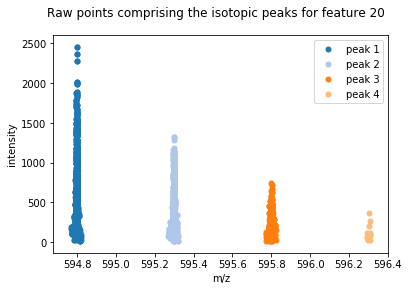

In [105]:
fig, ax = plt.subplots()
for idx,peak_id in enumerate(peak_ids):
    peak_points_df = summed_ms1_region_df.loc[summed_ms1_region_df.feature_peak_id==peak_id]
    ax.plot(peak_points_df.mz, peak_points_df.intensity, marker='o', color=tableau20[idx], linestyle='', ms=5, label="peak {}".format(peak_id))
plt.legend(loc='best')
plt.xlabel('m/z')
plt.ylabel('intensity')
plt.suptitle('Raw points comprising the isotopic peaks for feature {}'.format(feature_id))
plt.margins(0.06)
plt.show()

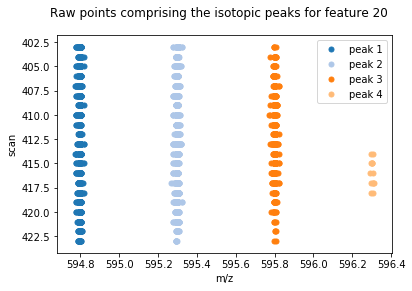

In [106]:
fig, ax = plt.subplots()
for idx,peak_id in enumerate(peak_ids):
    peak_points_df = summed_ms1_region_df.loc[summed_ms1_region_df.feature_peak_id==peak_id]
    ax.plot(peak_points_df.mz, peak_points_df.scan, marker='o', color=tableau20[idx], linestyle='', ms=5, label="peak {}".format(peak_id))
plt.legend(loc='best')
plt.xlabel('m/z')
plt.ylabel('scan')
plt.gca().invert_yaxis()
plt.suptitle('Raw points comprising the isotopic peaks for feature {}'.format(feature_id))
plt.margins(0.06)
plt.show()

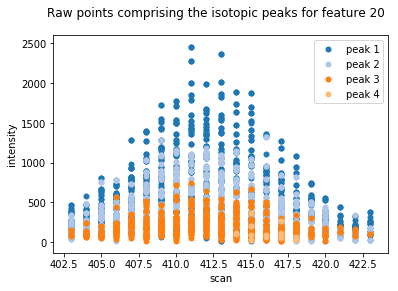

In [107]:
fig, ax = plt.subplots()
for idx,peak_id in enumerate(peak_ids):
    peak_points_df = summed_ms1_region_df.loc[summed_ms1_region_df.feature_peak_id==peak_id]
    ax.plot(peak_points_df.scan, peak_points_df.intensity, marker='o', color=tableau20[idx], linestyle='', ms=5, label="peak {}".format(peak_id))
plt.legend(loc='best')
plt.xlabel('scan')
plt.ylabel('intensity')
plt.suptitle('Raw points comprising the isotopic peaks for feature {}'.format(feature_id))
plt.margins(0.06)
plt.show()

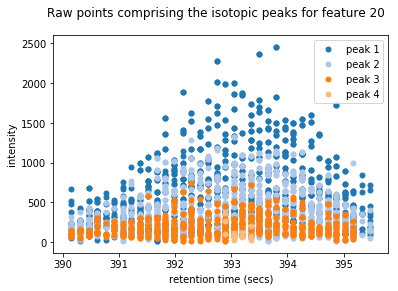

In [108]:
fig, ax = plt.subplots()
for idx,peak_id in enumerate(peak_ids):
    peak_points_df = summed_ms1_region_df.loc[summed_ms1_region_df.feature_peak_id==peak_id].copy()
    peak_points_df.sort_values(by=['raw_frame_id'], inplace=True)
    ax.plot(peak_points_df.retention_time_secs, peak_points_df.intensity, marker='o', color=tableau20[idx], linestyle='', ms=5, label="peak {}".format(peak_id))
plt.legend(loc='best')
plt.xlabel('retention time (secs)')
plt.ylabel('intensity')
plt.suptitle('Raw points comprising the isotopic peaks for feature {}'.format(feature_id))
plt.margins(0.06)
plt.show()

In [109]:
summed_ms1_region_df.head()

,feature_id,feature_point_id,feature_peak_id,raw_frame_id,raw_point_id,mz,scan,intensity,retention_time_secs
0,20,1,1,5108,16886,594.797945,403,114,390.151770
1,20,1,1,5112,16772,594.797945,403,74,390.456859
2,20,1,1,5112,16772,594.797945,403,74,390.456859
3,20,1,1,5118,17340,594.794099,403,263,390.913931
4,20,1,1,5120,17204,594.790254,403,136,391.066211


In [110]:
summed_ms1_region_df.rename(columns={"retention_time_secs":"rt"}, inplace=True)

In [111]:
# get the raw frame point's intensity
min_mz = summed_ms1_region_df.mz.min()
max_mz = summed_ms1_region_df.mz.max()
min_scan = summed_ms1_region_df.scan.min()
max_scan = summed_ms1_region_df.scan.max()
min_rt = summed_ms1_region_df.rt.min()
max_rt = summed_ms1_region_df.rt.max()

db_conn = sqlite3.connect(CONVERTED_DATABASE_NAME)
raw_points_in_region_df = pd.read_sql_query("select * from frames where retention_time_secs >= {} and retention_time_secs <= {} and scan >= {} and scan <= {} and mz >= {} and mz <= {}".format(min_rt, max_rt, min_scan, max_scan, min_mz, max_mz), db_conn)
db_conn.close()

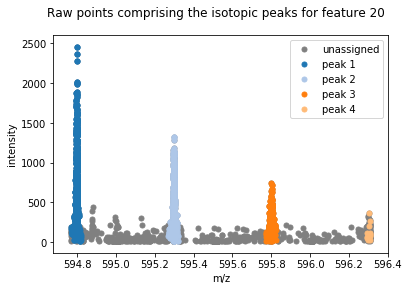

In [112]:
fig, ax = plt.subplots()
ax.plot(raw_points_in_region_df.mz, raw_points_in_region_df.intensity, marker='o', color='grey', linestyle='', ms=5, label="unassigned")
for idx,peak_id in enumerate(peak_ids):
    peak_points_df = summed_ms1_region_df.loc[summed_ms1_region_df.feature_peak_id==peak_id]
    ax.plot(peak_points_df.mz, peak_points_df.intensity, marker='o', color=tableau20[idx], linestyle='', ms=5, label="peak {}".format(peak_id))
plt.legend(loc='best')
plt.xlabel('m/z')
plt.ylabel('intensity')
plt.suptitle('Raw points comprising the isotopic peaks for feature {}'.format(feature_id))
plt.margins(0.06)
plt.show()

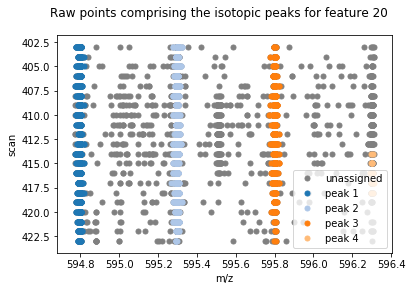

In [113]:
fig, ax = plt.subplots()
ax.plot(raw_points_in_region_df.mz, raw_points_in_region_df.scan, marker='o', color='grey', linestyle='', ms=5, label="unassigned")
for idx,peak_id in enumerate(peak_ids):
    peak_points_df = summed_ms1_region_df.loc[summed_ms1_region_df.feature_peak_id==peak_id]
    ax.plot(peak_points_df.mz, peak_points_df.scan, marker='o', color=tableau20[idx], linestyle='', ms=5, label="peak {}".format(peak_id))
plt.legend(loc='best')
plt.xlabel('m/z')
plt.ylabel('scan')
plt.gca().invert_yaxis()
plt.suptitle('Raw points comprising the isotopic peaks for feature {}'.format(feature_id))
plt.margins(0.06)
plt.show()